In [1]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
shape_data = pd.read_csv('Dataset/trafficsigns_dataset/shape_preprocessed.csv')

In [3]:
# Declare the number of classes in the dataset
OUTPUT_CLASSES_SHAPE = 5

In [4]:
def plot_pie_chart(data, target, ax):
    """Plots a pie chart of the target distribution in data"""
    data[target].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=False, startangle=90, ax=ax)

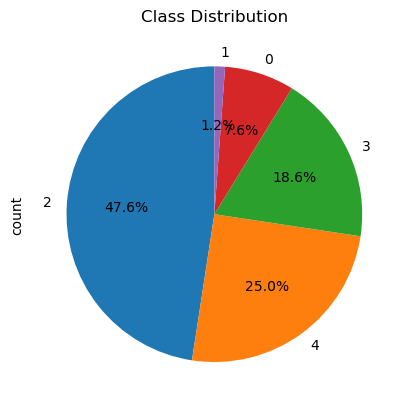

In [5]:
# A pie chart is used to visualize the class distribution
plot_pie_chart(data=shape_data, target='Shape', ax=None)
plt.title('Class Distribution')
plt.show()

In [6]:
# split shape data into train, test, and validation sets
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(shape_data, test_size=0.2, random_state=42, stratify=shape_data['Shape'])
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data['Shape'])

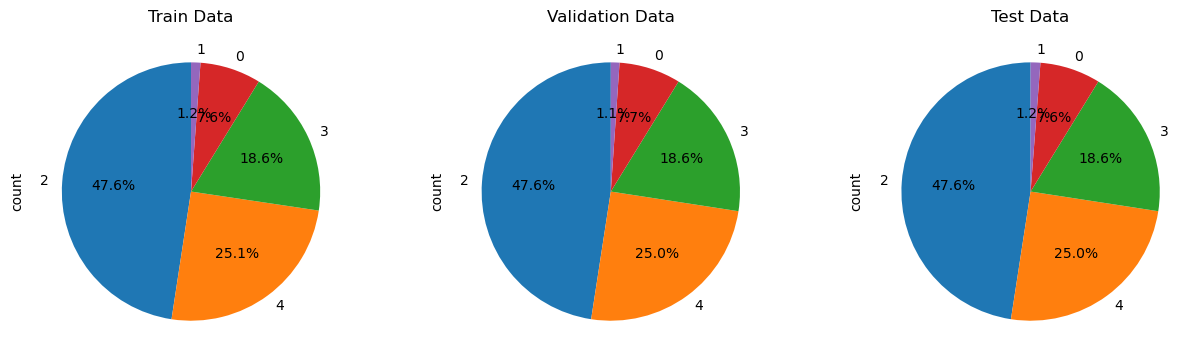

In [7]:
# Create a figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 3, figsize=(15, 15))  # Adjust the figsize

# Plot the train pie chart in the first subplot
plot_pie_chart(data=train_data, target='Shape', ax=axs[0])
axs[0].set_title('Train Data')

# Plot the validation pie chart in the second subplot
plot_pie_chart(data=val_data, target='Shape', ax=axs[1])
axs[1].set_title('Validation Data')

# Plot the test pie chart in the third subplot
plot_pie_chart(data=test_data, target='Shape', ax=axs[2])
axs[2].set_title('Test Data')
plt.subplots_adjust(wspace=0.3)  

# Display the plot
plt.show()

In [8]:
train_data.head()

,Path,Shape
3617,Dataset/trafficsigns_dataset/round/trafficdire...,2
592,Dataset/trafficsigns_dataset/square/parking/00...,3
32,Dataset/trafficsigns_dataset/diamond/rightofwa...,0
380,Dataset/trafficsigns_dataset/square/laneend/00...,3
1846,Dataset/trafficsigns_dataset/triangle/warning/...,4


In [9]:
# Convert the boolean encoding to integer
def bool_to_int(df_encoded) -> pd.DataFrame:
    """Convert boolean encoding to integer encoding"""
    for col in df_encoded.columns:
        if df_encoded[col].dtype == bool:
            df_encoded[col] = df_encoded[col].astype(int)
    return df_encoded

In [10]:
# One-hot encode 'Shape' column in the train data
train_data = pd.get_dummies(train_data, columns=['Shape'])

# One-hot encode 'Shape' column in the validation data
val_data = pd.get_dummies(val_data, columns=['Shape'])

# One-hot encode 'Shape' column in the test data
test_data = pd.get_dummies(test_data, columns=['Shape'])

In [11]:
# Convert boolean encoding to integer encoding
train_data = bool_to_int(train_data)
val_data = bool_to_int(val_data)
test_data = bool_to_int(test_data)

train_data.head()

,Path,Shape_0,Shape_1,Shape_2,Shape_3,Shape_4
3617,Dataset/trafficsigns_dataset/round/trafficdire...,0,0,1,0,0
592,Dataset/trafficsigns_dataset/square/parking/00...,0,0,0,1,0
32,Dataset/trafficsigns_dataset/diamond/rightofwa...,1,0,0,0,0
380,Dataset/trafficsigns_dataset/square/laneend/00...,0,0,0,1,0
1846,Dataset/trafficsigns_dataset/triangle/warning/...,0,0,0,0,1


In [12]:
# print the shape of the train, validation, and test sets
print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 2219, Val Data: 740, Test Data: 740


In [13]:
# # convert the target column to string to work with keras ImageDataGenerator
# train_data['Shape'] = train_data['Shape'].astype('str')
# val_data['Shape'] = val_data['Shape'].astype('str')
# test_data['Shape'] = test_data['Shape'].astype('str')

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# normalize pixel values and build a data generator
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# normalize pixel values and build a data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# choose 32 as the batch size
batch_size = 32

# train and validation generators
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Path",
        y_col=train_data.columns[1:],
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Path",
        y_col=val_data.columns[1:],
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='raw')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,  # make sure you have a dataframe for test data
        directory='./',
        x_col="Path",
        y_col=test_data.columns[1:],
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='raw')

2024-05-11 23:04:30.160939: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-11 23:04:30.192227: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 23:04:30.779018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 2219 validated image filenames.
Found 740 validated image filenames.
Found 740 validated image filenames.


In [15]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name="F1-score"):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [16]:
import tensorflow as tf

def build_model():
    model = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        #VGG block 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        #VGG block 3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE),
    ])

    return model

In [22]:
def compile_model(model):
    model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.AUC(name="AUC", curve="ROC")])

    return model

In [23]:
def train_model(model, train_generator, validation_generator, epochs=50):
    history = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

    return history

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def metrics(model):
    # Generate predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    # Get true labels
    y_true = test_generator.classes
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    # Generate classification report
    report = classification_report(y_true, y_pred_classes)
    print(report)



In [27]:
def pipeline_base():
    model = build_model()
    model = compile_model(model)
    history = train_model(model, train_generator, validation_generator)
    plot_learning_curve(history.history['loss'], history.history['val_loss'], history.history['AUC'], history.history['val_AUC'], "AUC")
    #metrics(model)

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


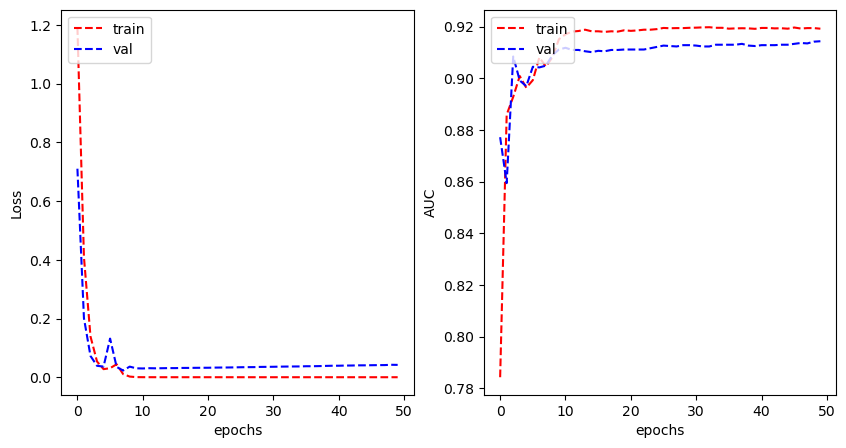

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


AttributeError: 'DataFrameIterator' object has no attribute 'classes'

In [26]:
pipeline_base()

In [36]:
def build_model_regularised(reg_lambda):
    model = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        #VGG block 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        #VGG block 3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(OUTPUT_CLASSES_SHAPE),
    ])

    return model

In [29]:
def compile_model_regularised(model):
    model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.AUC(name="AUC", curve="ROC")])

    return model

In [30]:
def train_model_regularised(model, train_generator, validation_generator, epochs=50):
    history = model.fit(train_generator, validation_data = validation_generator, epochs=epochs, verbose=0)

    return history

In [34]:
def pipeline_regularised(reg_lambda):
    model = build_model_regularised(reg_lambda)
    model = compile_model_regularised(model)
    history = train_model_regularised(model, train_generator, validation_generator, epochs=100)
    plot_learning_curve(history.history['loss'], history.history['val_loss'], history.history['AUC'], history.history['val_AUC'], "AUC")
    #metrics(model)

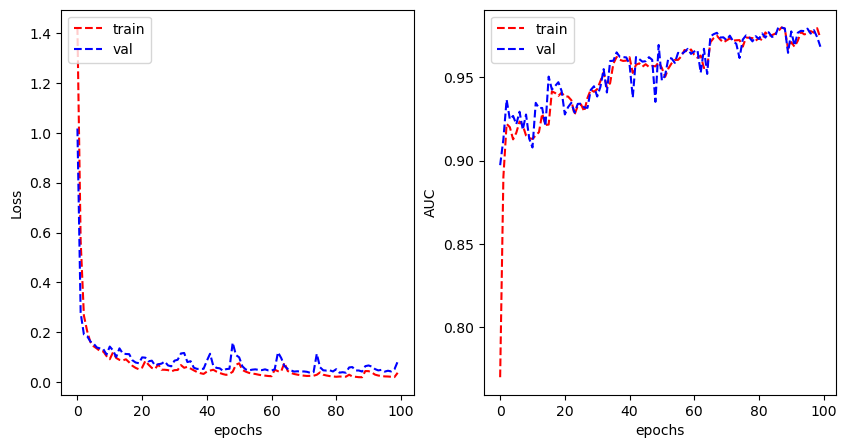

In [37]:
pipeline_regularised(0.001)